In [16]:
# Export to html
!jupyter nbconvert --to html si-nets.ipynb

[NbConvertApp] Converting notebook si-nets.ipynb to html
[NbConvertApp] Writing 719365 bytes to si-nets.html


## Imports and setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import SGD, LBFGS
from sklearn.model_selection import train_test_split
from spint.gravity import Gravity

In [2]:
class TwoLayerSI(nn.Module):
    """
    Extremely basic two layer feedforward neural net for spatial interaction models.
    Based on Fischer and Gopal (1994).
    Second activation may be unnecessary?

    Input data takes the following shape: (Oi, Dj, dij) where...
        - Oi is potential for flow generation at loc i
        - Dj is potential draw for flows to loc j
        - dij is the distance between locs i and j
    Output data takes the form Tij, the estimated flow from i to j.
    """

    def __init__(self, H):
        super(TwoLayerSI, self).__init__()
        self.lin1 = nn.Linear(3, H)  # layer 1 (linear weights/biases)
        self.lin2 = nn.Linear(H, 1)  # layer 2 (linear weights/biases)
        self.sigma = nn.Sigmoid()    # activation function
    
    def forward(self, x):
        return self.sigma(self.lin2(self.sigma(self.lin1(x))))

## Load data

In [3]:
tofloat = lambda x : float(x)
austria = pd.read_csv('../data/austria.csv', converters={'Oi' : tofloat, 'Dj' : tofloat, 'Dij' : tofloat, 'Data' : tofloat})

origins = austria['Oi'].values
destinations = austria['Dj'].values
distances = austria['Dij'].values
observed = austria['Data'].values

In [4]:
# Remove self flows
raw_origins = np.delete(origins, np.arange(0, origins.size, 10))
raw_destinations = np.delete(destinations, np.arange(0, destinations.size, 10))
raw_distances = np.delete(distances, np.arange(0, distances.size, 10))
raw_observed = np.delete(observed, np.arange(0, observed.size, 10))

In [5]:
# Log-transform data to (0, 1]
origins = np.log(raw_origins)/np.log(raw_origins.max())
destinations = np.log(raw_destinations)/np.log(raw_destinations.max())
distances = np.log(raw_distances)/np.log(raw_distances.max())
observed = np.log(raw_observed)/np.log(raw_observed.max())

In [6]:
# Put back into dataframe for later
data = pd.DataFrame(data=np.column_stack((origins, destinations, distances, observed)), columns=['Oi', 'Dj', 'Dij', 'Tij'])

In [7]:
N = len(origins)
M = len(destinations)

## Instantiate and train neural net
This is a *very* overfitted example (the train/test split is 100/0 lol) for verification that the neural net at least kinda works.

In [8]:
H = 30  # number of hidden units
nepochs = 1500
net = TwoLayerSI(H).double()

In [9]:
# Main training loop
bsz = int(N/5)  # training batch size
net.zero_grad()
criterion = nn.MSELoss()
expected = torch.from_numpy(observed)
optimizer = SGD(net.parameters(), lr=0.1)

for epoc in range(nepochs):
    for iter in range(bsz):    
        i = np.random.randint(0, N)  # randomly select training data   
        input = torch.tensor([origins[i], destinations[i], distances[i]], requires_grad=True)
        optimizer.zero_grad()
        
        output = net(input)  # forward
        loss = criterion(output, expected[i])
        loss.backward()  # backward
        optimizer.step()  # optimize

In [10]:
# Get predictions
predictions = np.zeros((N,))
for i in range(N):
    input = torch.tensor([origins[i], destinations[i], distances[i]])
    predictions[i] = net(input)

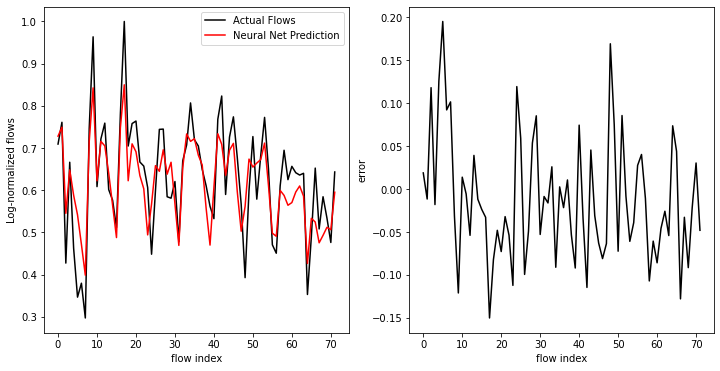

In [11]:
# Plot results
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
ax1.plot(range(N), observed, '-k', range(N), predictions, '-r')
ax1.legend(['Actual Flows', 'Neural Net Prediction'])
ax1.set_xlabel('flow index')
ax1.set_ylabel('Log-normalized flows')

ax2.plot(range(N), predictions - observed, '-k')
ax2.set_xlabel('flow index')
ax2.set_ylabel('error')
plt.show()

## Unconstrained Gravity model

In [12]:
# Reformat data as integers and remove self flows
iobserved = np.array([int(el) for el in raw_observed])
iorigins = np.array([int(el) for el in raw_origins])
idestinations = np.array([int(el) for el in raw_destinations])
idistances = np.array([int(el) for el in raw_distances])

In [13]:
# Fit model to data
model = Gravity(iobserved, iorigins, idestinations, idistances, 'exp')
beta = model.params

In [14]:
# Predict flows from data using results from Gravity regression
gpredict = np.exp(beta[0] * np.ones((N,)) + beta[1] * np.log(iorigins) + beta[2] * np.log(idestinations) + beta[3] * np.log(idistances))

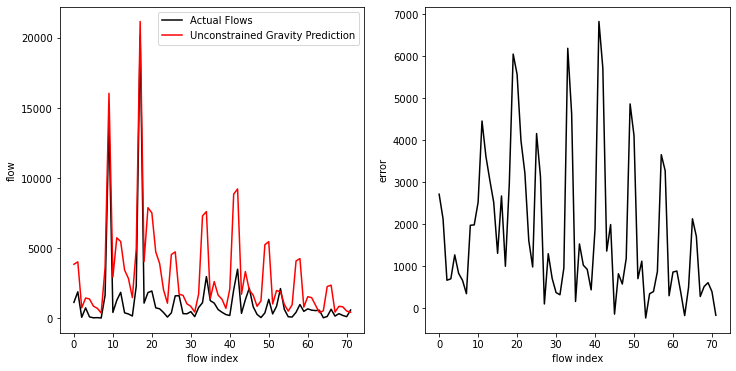

In [15]:
# Plot results
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
ax1.plot(range(N), iobserved, '-k', range(N), gpredict, '-r')
ax1.legend(['Actual Flows', 'Unconstrained Gravity Prediction'])
ax1.set_xlabel('flow index')
ax1.set_ylabel('flow')

ax2.plot(range(N), gpredict - iobserved, '-k')
ax2.set_xlabel('flow index')
ax2.set_ylabel('error')
plt.show()

## TODO
- optimize training procedure
- pick a better metric for validation
- plug in cooler dataset
- figure out what NN SI research actually looks like (open questions)

### Current NN SI research threads:
- (Yao et. al. 2020) *Spatial Origin-Destination Flow Imputation Using Graph Convolutional Networks*. Using relational graph convolutional networks (R-GCNs) because they work well on nonlinear graph structures. They use this to impute missing flows.
- (Pourebrahim et. al. 2019) *Trip distribution modeling with Twitter data*. Compared gravity model, ANN, and random forest on a dataset with and without the addition of Twitter data.
- ~90% of the articles appear to be "look you can use an NN for SI!" and it usually works better than gravity/whatever conventional model they use
- the other 10% of the articles appear to be "we slapped a NN on an SI problem and oh baby it worked!"

Gathered these ideas from a Google Scholar search of who cited (Openshaw 1993) and (Black 1995).

In [56]:
# Set up 80/10/10 train/validation/test split and fix nepochs
train_set, test_set = train_test_split(data, test_size=0.1)
train_set, val_set  = train_test_split(train_set, test_size=0.1)
nepochs = 1500

In [47]:
# Main training/validation loop for number of nodes in network
net.zero_grad()
criterion = nn.MSELoss()
train_X = train_set.drop(columns='Tij')
val_X = val_set.drop(columns='Tij')
train_expected = torch.from_numpy(train_set['Tij'].values)
val_expected = torch.from_numpy(val_set['Tij'].values)
optimizer = SGD(net.parameters(), lr=0.1)
skills = []

for H in np.linspace(5, 105, num=20):
    net = TwoLayerSI(int(H)).double()
    for epoc in range(nepochs):
        for i in range(len(train_X)):    
            input = torch.tensor(train_X.iloc[i], requires_grad=True)
            optimizer.zero_grad()
            
            output = net(input)  # forward
            loss = criterion(output, train_expected[i])
            loss.backward()  # backward
            optimizer.step()  # optimize
    
    # Validate
    val_y = torch.zeros((len(val_set),))
    for i in range(len(val_set)): val_y[i] = net(torch.tensor(val_X.iloc[i]))
    skill = criterion(val_y, val_expected)
    skills.append(skill.item())
    print(f'number of nodes = {int(H)}, validation error = {skill.item()}')

number of nodes = 5, validation error = 0.015286102865427574
number of nodes = 10, validation error = 0.015407393201498648
number of nodes = 15, validation error = 0.10949072225440916
number of nodes = 20, validation error = 0.008540503221357248
number of nodes = 26, validation error = 0.04920449716431017
number of nodes = 31, validation error = 0.05271515050215285
number of nodes = 36, validation error = 0.01784742836642489
number of nodes = 41, validation error = 0.006154131207630869
number of nodes = 47, validation error = 0.05091407158441495
number of nodes = 52, validation error = 0.04381142480582167
number of nodes = 57, validation error = 0.013284670757167659
number of nodes = 62, validation error = 0.018656533012364522
number of nodes = 68, validation error = 0.06220550786826306
number of nodes = 73, validation error = 0.008184564852272742
number of nodes = 78, validation error = 0.03279738548869425
number of nodes = 83, validation error = 0.019940912898668915
number of nodes =

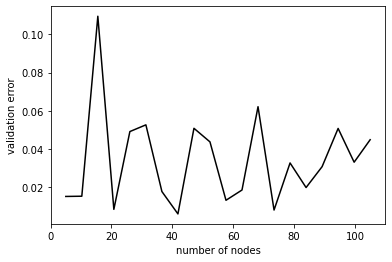

In [48]:
# Plot. No real pattern, but 20 seems to be good enough (and small enough for easy computation).
plt.plot(np.linspace(5, 105, num=20), skills, '-k')
plt.xlabel('number of nodes')
plt.ylabel('validation error')
plt.show()

In [57]:
H = 20  # set optimal number of nodes from now on

In [61]:
# Main training/validation loop for learning rate
net.zero_grad()
criterion = nn.MSELoss()
train_X = train_set.drop(columns='Tij')
val_X = val_set.drop(columns='Tij')
train_expected = torch.from_numpy(train_set['Tij'].values)
val_expected = torch.from_numpy(val_set['Tij'].values)
skills = []

for lr in np.logspace(-5, 1, num=7):
    net = TwoLayerSI(H).double()
    optimizer = SGD(net.parameters(), lr=lr)
    for epoc in range(int(nepochs)):
        for i in range(len(train_X)):    
            input = torch.tensor(train_X.iloc[i], requires_grad=True)
            optimizer.zero_grad()
            
            output = net(input)  # forward
            loss = criterion(output, train_expected[i])
            loss.backward()  # backward
            optimizer.step()  # optimize
    
    # Validate
    val_y = torch.zeros((len(val_set),))
    for i in range(len(val_X)): val_y[i] = net(torch.tensor(val_X.iloc[i]))
    skill = criterion(val_y, val_expected)
    skills.append(skill.item())
    print(f'learning rate = {lr}, validation error = {skill.item()}')

learning rate = 1e-05, validation error = 0.03173007111991485
learning rate = 0.0001, validation error = 0.03276265060232325
learning rate = 0.001, validation error = 0.032500272533108214
learning rate = 0.01, validation error = 0.02487215383986675
learning rate = 0.1, validation error = 0.009038870680343498
learning rate = 1.0, validation error = 0.010408619479139678
learning rate = 10.0, validation error = 0.02580752711750856


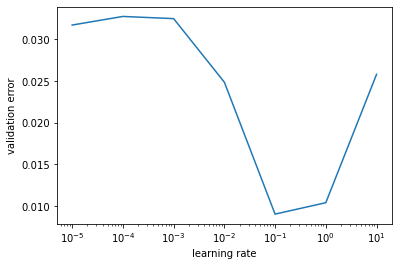

In [63]:
plt.semilogx(np.logspace(-5, 1, num=7), skills)
plt.xlabel('learning rate')
plt.ylabel('validation error')
plt.show()

In [64]:
lr = 0.1  # set optimal learning rate

In [65]:
# Train optimal net
net.zero_grad()
criterion = nn.MSELoss()
train_X = train_set.drop(columns='Tij')
val_X = val_set.drop(columns='Tij')
train_expected = torch.from_numpy(train_set['Tij'].values)
val_expected = torch.from_numpy(val_set['Tij'].values)
optimizer = SGD(net.parameters(), lr=lr)

for epoc in range(nepochs):
    for i in range(len(train_X)):     
        input = torch.tensor(train_X.iloc[i], requires_grad=True)
        optimizer.zero_grad()
        
        output = net(input)  # forward
        loss = criterion(output, train_expected[i])
        loss.backward()  # backward
        optimizer.step()  # optimize

In [73]:
# Test optimal hyperparameters on test set
test_X = test_set.drop(columns='Tij')
predictions = np.zeros((len(test_X),))
for i in range(len(test_X)): predictions[i] = net(torch.tensor(test_X.iloc[i]))

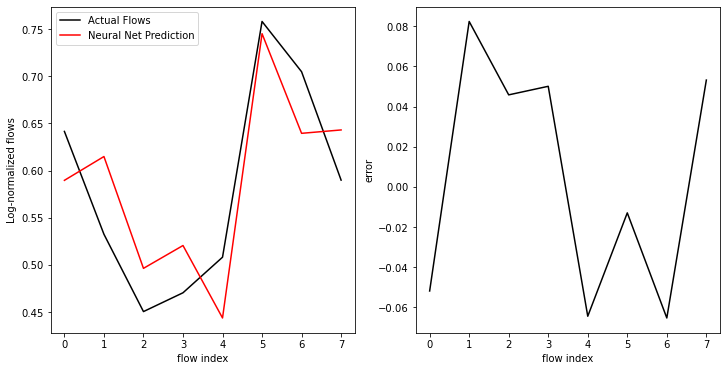

In [75]:
# Plot results
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
ax1.plot(range(len(test_X)), test_set['Tij'], '-k', range(len(test_X)), predictions, '-r')
ax1.legend(['Actual Flows', 'Neural Net Prediction'])
ax1.set_xlabel('flow index')
ax1.set_ylabel('Log-normalized flows')

ax2.plot(range(len(test_X)), predictions - test_set['Tij'], '-k')
ax2.set_xlabel('flow index')
ax2.set_ylabel('error')
plt.show()

In [17]:
# Test on whole set of flows
data_X = data.drop(columns='Tij')
predictions = np.zeros((len(data_X),))
for i in range(len(data_X)): predictions[i] = net(torch.tensor(data_X.iloc[i]))

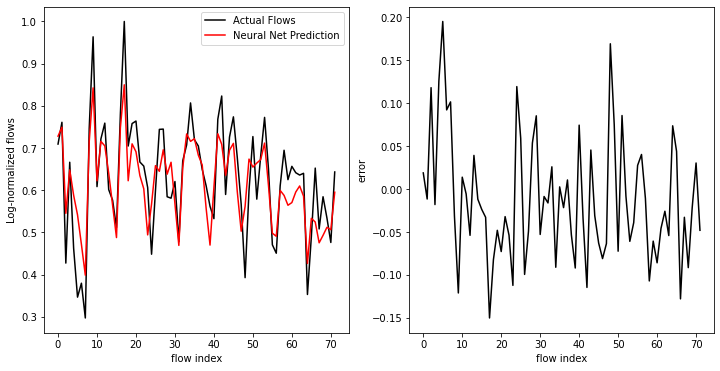

In [18]:
# Plot results -- I think the validation procedure isn't perfect, as this isn't really that different from the guessed parameters.
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
ax1.plot(range(len(data_X)), data['Tij'], '-k', range(len(data_X)), predictions, '-r')
ax1.legend(['Actual Flows', 'Neural Net Prediction'])
ax1.set_xlabel('flow index')
ax1.set_ylabel('Log-normalized flows')

ax2.plot(range(len(data_X)), predictions - data['Tij'], '-k')
ax2.set_xlabel('flow index')
ax2.set_ylabel('error')
plt.show()